Define num_states (later called $n$) and cost matrices $Q_1$ (asymmetric) and $Q_2$ (symmetric).

In [18]:
import numpy
from math import factorial, ceil, log2

# variables
num_states = 3
num_state_qubits = ceil(log2(num_states))
value_pair = (2, 1)
num_eval_qubits = 4
Q1 = numpy.array([
    [0, 19.2, 20.5],
    [10, 0, 3.23],
    [2.4, 12, 0]])
Q2 = numpy.array([
    [0, 10, 20],
    [10, 0, 3],
    [20, 3, 0]])

if num_states <= 1:
    raise ValueError("The number of permuted states must be greater than 1.")
if min(value_pair) < 0 or max(value_pair) >= num_states:
    raise ValueError("The states to compare must be in [0, num_states[.")
if value_pair[0] == value_pair[1]:
    raise ValueError("The states to compare must be different.")
if num_eval_qubits <= 1:
    raise ValueError("The number of evaluation qubits must be greater than 1.")
for Q in [Q1, Q2]:
    if Q.ndim != 2:
        raise ValueError("Dimension of cost matrix must be 2.")
    if numpy.any(Q.real != Q):
        raise ValueError("Cost matrix must be real.")
    if Q.shape[0] != num_states or Q.shape[1] != num_states:
        raise ValueError("Cost matrix dimensions must have number of states as size.")
    if numpy.any(Q < 0):
        raise ValueError("Cost matrix must have positive or zero entries.")
    if numpy.any(Q.diagonal() != 0):
        raise ValueError("Cost matrix must be zero on the diagonal.")
if numpy.all(Q1.T == Q1):
    raise ValueError("Cost matrix Q1 should be asymmtric.")
if numpy.any(Q2.T != Q2):
    raise ValueError("Cost matrix Q2 should be symmtric.")

# setup for quick tests
from itertools import permutations
from qiskit import Aer, transpile, QuantumCircuit, QuantumRegister
import random
backend_sim = Aer.get_backend('qasm_simulator')

def evaluate_perm(permutation, adjusted_costs):
    evaluation = 0
    for i in range(len(permutation)):
        idx1 = permutation[i]
        idx2 = permutation[(i + 1) % len(permutation)]
        evaluation += adjusted_costs[idx1, idx2]
    return evaluation

def translate_counts(count_dict):
    global num_states, num_state_qubits, num_eval_qubits
    
    tr_counts = dict()
    permutation_regs = []
    result_regs = []
    aux_regs = []
    
    for bitstring in count_dict:
        reduced_bitstring = bitstring
        key_string = ""
        
        # permutation at the end
        perm = []
        for _ in range(num_states):
            state = int(reduced_bitstring[-num_state_qubits:], 2)
            perm.append(state)
            reduced_bitstring = reduced_bitstring[:-num_state_qubits]
        perm = tuple(perm)
        permutation_regs.append(perm)
        key_string += f"permutation={perm}"
        
        # before permutation
        perm_eval = int(reduced_bitstring[-num_eval_qubits:], 2)
        result_regs.append(perm_eval)
        reduced_bitstring = reduced_bitstring[:-num_eval_qubits]
        key_string += f", perm_eval={perm_eval}"
        
        # remaining aux
        aux = int(reduced_bitstring, 2)
        aux_regs.append(aux)
        key_string += f", aux={aux}"
        
        key_string += f", bitstring={bitstring}"
        tr_counts[key_string] = count_dict[bitstring]
    
    return tr_counts, permutation_regs, result_regs, aux_regs

# 1. Evaluating Permutations

Given a real $n \times n$ matrix $Q$ (zero based indexed) consisting of entries describing a cost $Q_{ij}\geq 0$ with $\forall i: Q_{ii}=0$, a permutation over $n$ states $\pi=\pi_0\dots\pi_{n-1}$ is evaluated as $VAL_{\bar Q}(\pi)=\sum_{k < n} \bar Q_{\pi_k \pi_{k+1 \text{ mod } n}}$. $\bar Q$ is an adjusted version of $Q$, so that $\bar Q_{i,j} \in \mathbb{N}$ and $\max_\pi (VAL_{\bar Q}(\pi)) < 2^n_{EVAL}$ for some $n_{EVAL} \in \mathbb{N^+}$. Using the sum of maximal entries column- and row-wise $MAXSUM_{col}(Q) = \sum_{j<n} \max_i Q_{ij}$ and $MAXSUM_{row}(Q) = \sum_{i<n} \max_j Q_{ij}$, one representation of the adjusted matrix can be computed with $\bar Q_{ij} = \left\lfloor \frac{Q_{ij} \cdot (2^n_{EVAL}-1)}{\min(MAXSUM_{col}(Q), MAXSUM_{row}(Q))}\right\rfloor$. Because the states in the permutation are unique, $VAL_{Q}(\pi)$ sums up entries which are column- and row-wise unique. This means $\min(MAXSUM_{col}(Q), MAXSUM_{row}(Q)) \geq \max_\pi VAL_{Q}(\pi)$ and the evalution is bounded $VAL_{\bar Q}(\pi)=\sum_{k < n} \bar Q_{\pi_k \pi_{k+1 \text{ mod } n}} \leq \sum_{k < n} \frac{Q_{\pi_k \pi_{k+1 \text{ mod } n}} \cdot (2^n_{EVAL}-1)}{\min(MAXSUM_{col}(Q), MAXSUM_{row}(Q))} \leq \frac{VAL_{Q}(\pi)\cdot (2^n_{EVAL} - 1)}{\max_\pi VAL_{Q}(\pi)} < 2^n_{EVAL}$ as required. In the quantum circuit each $\pi_i$ can be stored in $n_{\pi} = \lceil \log_2 n\rceil$ qubits, so the hermitian cost operator $\hat C$ is represented by a $n \cdot n_\pi \times n \cdot n_\pi$ matrix $C$ (zero based indexed) with $\forall \pi, \sum_{i<n} \pi_i \cdot 2^{n_\pi \cdot i} = \Pi: C_{\Pi\Pi} = VAL_{\bar Q}(\pi)$. In order to compute $VAL_{\bar Q}(\pi)$ for a permutation $|\Pi\rangle = \bigotimes_{i<n} |\pi_i\rangle$, adjacend permutation states are checked with the value pairs in $V = \{(Val_0, Val_1)| Val_0, Val_1\in\mathbb{N^0} \land Val_0,Val_1 <n \land Val_0 \neq Val_1 \}$. If the pair is contained in the permuation as adjacend states (written as $(Val_0, Val_1)\in\pi$), $\bar Q_{Val_0Val_1}$ is added to a sum in another register. Value pairs $(Val_0, Val_1): \bar Q_{Val_0Val_1}=0$ can be skipped. The resulting sum is $\sum_{(Val_0,Val_1)\in V \land (Val_0,Val_1)\in \pi} \bar Q_{Val_0Val_1} = VAL_{\bar Q}(\pi)$.

## 1.1 Comparing permutation states with value pairs

The comparison of a single value pair $(Val_0,Val_1)\in V$ with all adjacend permutation states $\forall k <n: (Val_0,Val_1) = (\pi_k, \pi_{k+1 \text{ mod } n})$ is done via multicontrolled NOT gates. Before each MCNOT gate, NOT gates are added according to the inverted bit pattern of $(i,j)$. Since each value pair can only exist once in a permutation, the controlled NOT gates can share a target qubit. The gates can be parallelized by checking sets of adjacend permutation states without overlap.
The index sets are  
$\{(2k, 2k+1) | 0 \leq k < \lfloor n/2\rfloor \}$,  $\{(2k + 1, 2k+2 \text{ mod } n) | 0 \leq k < \lfloor n/2 \rfloor\}$, $\{(n-1, 0)\}$ if $n>1 \land n \text{ odd}$.

If the adjusted cost matrix $\bar Q$ is symmetric, the comparisons for $(Val_0,Val_1)$ and $(Val_1,Val_0)$ are combined and each permutation state can be compared seperatly $\forall k<n: (Val_0 = \pi_k) \lor (Val_1 =  \pi_k)$ with one target qubit each. The $n$ target qubits are not uncomputed and later grouped as CCNOT gate controls with $\{(k, k+1 \text{ mod } n) | 0 \leq k < n\}$ or $\{(0, 1)\}$ if $n=2$, otherwise acting on a final single target. The comparison is done in two steps: 
1. Calculate the bitwise XOR $(\widehat{Val})_2=(Val_0)_2 \veebar (Val_1)_2$ and find an index $r$ with $(\widehat{Val})_{2_r}=1$. Using this index as a control, perform CNOTs on all other set bit indices $s: s\neq r \land (\widehat{Val})_{2_s}=1$.
2. Secondly add NOT gates according to the inverted bit pattern of $Val_0$ if $Val_{0_r}=0$ or $Val_1$ if $Val_{1_r}=0$ and use a MCNOT gate on all indices but $r$.

Because of the high ancilla demand for multicontrolled gates with low depth, accumulation qubits of the later computed sum $VAL_{\bar Q}(\pi)$ may be borrowed as ancilla qubits using the $MCXBV$ gate. In summary, both cases use $n$ MCNOT gates, each with $2n_\pi$ controls for the asymmetric case and $n_\pi-1$ controls for the symmetric case. The symmetric case uses $n$ (for $n>2$) additional CCNOT gates in the end and needs $n$ additional non-borrowed ancillas, which are not directly uncomputed. 
The number of uncomputed ancillas for the cases are $n_{aux, sym} = n \cdot \max(0, n_\pi -3)$ and $n_{aux, asym} = \lfloor n/2\rfloor \cdot \max(0, 2n_\pi -2)$. 
The circuit for the symmetric case performs $PPCmp_{sym}(n, (Val_0, Val_1)) |\Pi\rangle \otimes |0\rangle^n \otimes |0\rangle \otimes |0\rangle^{n_{aux, sym}} = |\Pi\rangle \otimes \left( \bigotimes_{k<n} |(Val_0 = \pi_k) \lor (Val_1 =  \pi_k)\rangle \right) \otimes |(Val_0, Val_1)\in \pi \lor (Val_1, Val_0)\in \pi \rangle \otimes |0\rangle^{n_{aux, sym}}$ and for the asymmetric case $PPCmp_{asym}(n, (Val_0, Val_1))|\Pi\rangle \otimes |0\rangle \otimes |0\rangle^{n_{aux, asym}} = |\Pi\rangle  \otimes |(Val_0, Val_1)\in \pi \rangle \otimes |0\rangle^{n_{aux, asym}}$.
In both cases the MCNOT gates are practically parallelized, for the asymmetric case there are a maximum of 3 iterations to cover all comparisons, the exception being the final $n$ CCNOTs on the shared target. The depth amounts to $depth(PPCmp_{asym}(n, (Val_0, Val_1))) \leq 3 \cdot depth(MCNOT(2n_\pi)) + n\cdot depth(CCNOT) = \mathcal{O}(n)$ and $depth(PPCmp_{sym}(n, (Val_0, Val_1)) \leq depth(MCNOT(n_\pi-1)) + n\cdot depth(CCNOT) = \mathcal{O}(n)$. The sizes are $size(PPCmp_{asym}(n, (Val_0, Val_1))) = n \cdot size(MCNOT(2n_\pi)) = \mathcal{O}(n \log_2(n))$ and $size(PPCmp_{sym}(n, (Val_0, Val_1))) = n \cdot size(MCNOT(n_\pi-1)) + n\cdot size(CCNOT)= \mathcal{O}(n \log_2(n))$.

### 1.1.1 Asymmetric case

In [15]:
from library.comparators import PermPairComparator

PermPairComparator(num_states, value_pair=value_pair, is_symmetric=False).decompose().draw(fold=-1)

┌───────────────┐                 ┌───────────────┐
perm_0_0: ┤0              ├─────────────────┤2              ├
          │               │                 │               │
perm_0_1: ┤1              ├─────────────────┤3              ├
          │               │┌───────────────┐│               │
perm_1_0: ┤2              ├┤0              ├┤               ├
          │               ││               ││               │
perm_1_1: ┤3              ├┤1              ├┤               ├
          │               ││               ││               │
perm_2_0: ┤  Cmp(=(2, 1)) ├┤2              ├┤0 Cmp(=(2, 1)) ├
          │               ││               ││               │
perm_2_1: ┤               ├┤3 Cmp(=(2, 1)) ├┤1              ├
          │               ││               ││               │
     cmp: ┤4              ├┤4              ├┤4              ├
          │               ││               ││               │
   aux_0: ┤5              ├┤5              ├┤5              ├
          │               ││               ││               │
   aux_1: ┤6              ├┤6              ├┤6              ├
          └───────────────┘└───────────────┘└───────────────┘

### 1.1.2 Symmetric case

In [16]:
from library.comparators import PermPairComparator

PermPairComparator(num_states, value_pair=value_pair, is_symmetric=True).decompose().draw(fold=-1)

┌───────────────┐                                                 
 perm_0_0: ┤0              ├─────────────────────────────────────────────────
           │               │                                                 
 perm_0_1: ┤1              ├─────────────────────────────────────────────────
           │               │┌───────────────┐                                
 perm_1_0: ┤               ├┤0              ├────────────────────────────────
           │               ││               │                                
 perm_1_1: ┤  Cmp(={1, 2}) ├┤1              ├────────────────────────────────
           │               ││               │┌───────────────┐               
 perm_2_0: ┤               ├┤               ├┤0              ├───────────────
           │               ││  Cmp(={1, 2}) ││               │               
 perm_2_1: ┤               ├┤               ├┤1              ├───────────────
           │               ││               ││               │               
pre_cmp_0: ┤2              ├┤               ├┤  Cmp(={1, 2}) ├──■─────────■──
           └───────────────┘│               ││               │  │         │  
pre_cmp_1: ─────────────────┤2              ├┤               ├──■────■────┼──
                            └───────────────┘│               │  │    │    │  
pre_cmp_2: ──────────────────────────────────┤2              ├──┼────■────■──
                                             └───────────────┘┌─┴─┐┌─┴─┐┌─┴─┐
      cmp: ───────────────────────────────────────────────────┤ X ├┤ X ├┤ X ├
                                                              └───┘└───┘└───┘

## 1.2 Calculating the evaluation

First the adjusted cost matrix $\bar Q$ is computed classically from $Q$ in $\mathcal{O(n^2)}$ time.
Using the target of the previous comparators $PPCmp(n, (Val_0,Val_1))$  (meaning either $PPCmp_{sym}(n, (Val_0,Val_1))$ or $PPCmp_{asym}(n, (Val_0,Val_1))$) as the control, the values $\bar Q_{Val_0Val_1}$ are added using a $CtrlCnstHalfAdd$ in a register of size $n_{EVAL}$. Afterwards the control is uncomputed and the next value pair is compared. After $n^2 - n$ iterations (or $\frac{n^2 - n}{2}$ iterations for symmetric $\bar Q$) all value pairs are checked. The complete circuit computes  $EVAL(n, n_{EVAL}, Q) |\Pi\rangle  \otimes |0\rangle^{n_{EVAL}} \otimes |0\rangle^{n'_{aux}}= |\Pi\rangle \otimes |VAL_{\bar Q}(\pi)\rangle \otimes |0\rangle^{n'_{aux}}$, with 

$n'_{aux} = \left\{ \begin{array}{cl}
n+1+n_{aux,sym} & : \ \bar Q = \bar Q^T \\
1+n_{aux,asym} & : \  \bar Q \neq \bar Q^T
\end{array} \right.$.

Regardless of the symmetry, the $\mathcal{O}(n^2)$ iterations over lead to $size(EVAL(n, n_{EVAL}, Q)) = \mathcal{O} (n^3 + n^2 \cdot n_{EVAL})$ and  $depth(EVAL(n, n_{EVAL}, Q)) = \mathcal{O} (n^3\log_2 n + n^2 \cdot n_{EVAL})$. Choosing $n_{EVAL} = \mathcal{Poly(n)} = \mathcal{O}(n^c), c \in \mathbb{N}$ constant, is necessary to keep the circuit in polynomial time and size bounds.

### 1.2.1 asymmetric case

Adjusted cost matrix =
[[0 6 7]
 [3 0 1]
 [0 4 0]]


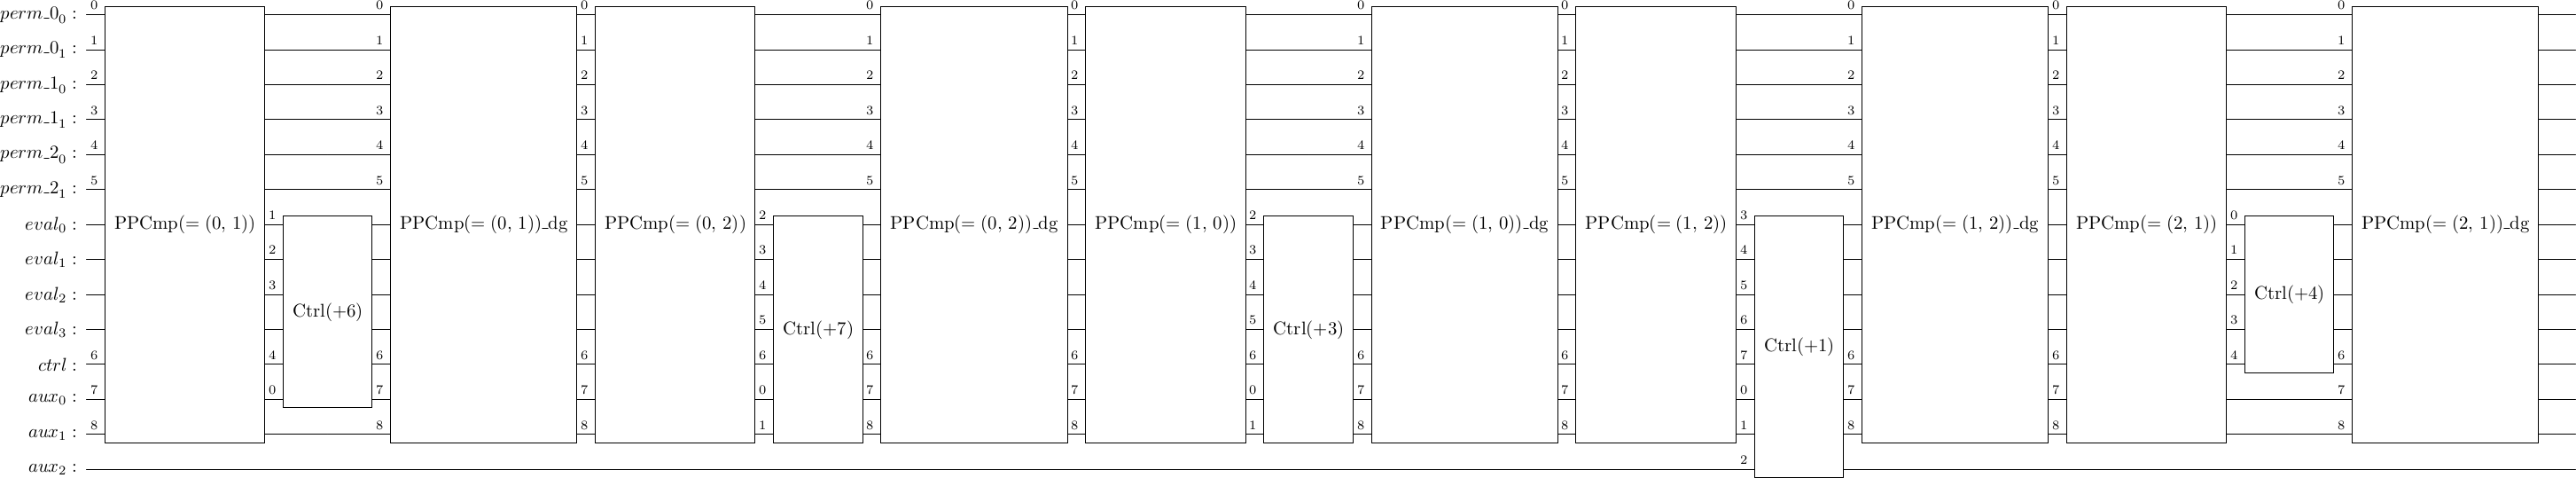

In [21]:
from library.permutations import PermEvaluation

perm_eval_asym = PermEvaluation(num_states, Q1, num_eval_qubits)
print("Adjusted cost matrix =")
print(perm_eval_asym.adjusted_costs)
perm_eval_asym.decompose().draw(fold=-1)

Quick test with $Q_1$ ($min(10, n!)$ random samples) for correctness.

In [ ]:
correct = True
samples = []
perm_eval_asym = PermEvaluation(num_states, Q1, num_eval_qubits)

for perm in random.sample(list(permutations(range(num_states))), min(10, factorial(num_states))):
    samples.append(f"permutation={perm}")
    
    qr_perm_states = []
    for i in range(num_states):
        qr_perm_states.append(QuantumRegister(num_state_qubits, f"perm_{i}"))
    qr_eval = QuantumRegister(num_eval_qubits, "eval")
    qr_aux = QuantumRegister(perm_eval_asym.num_ancillas, "aux")
    qc = QuantumCircuit(*qr_perm_states, qr_eval, qr_aux)
        
    for p_index, value in enumerate(perm):
        for index, bit in enumerate(reversed(bin(value)[2:])):
            if bit == '1':
                qc.x(qr_perm_states[p_index][index])
    
    qc.compose(perm_eval_asym, inplace=True)
    qc.measure_all()
    result_sim = backend_sim.run(transpile(qc, backend_sim), shots=100).result()
    tr_counts, _, result_regs, aux_regs = translate_counts(result_sim.get_counts())
    
    evaluation = evaluate_perm(perm, perm_eval_asym.adjusted_costs)
    if len(result_regs) > 1 or result_regs[0] != evaluation or aux_regs[0] != 0:
        print("Wrong result!")
        print(f"Input: permutation={perm}, perm_eval={evaluation}")
        print("State counts:", tr_counts)
        correct = False
            
if (correct):
    print("All of the random samples were correct:", samples)

All of the random samples were correct: ['permutation=(1, 0, 2, 3)', 'permutation=(2, 0, 1, 3)', 'permutation=(1, 0, 3, 2)', 'permutation=(2, 1, 0, 3)', 'permutation=(2, 1, 3, 0)', 'permutation=(1, 3, 0, 2)', 'permutation=(0, 1, 3, 2)', 'permutation=(2, 0, 3, 1)', 'permutation=(0, 3, 2, 1)', 'permutation=(1, 2, 3, 0)']


### 1.2.2 Symmetric Case

Adjusted cost matrix =
[[0 3 6]
 [3 0 0]
 [6 0 0]]


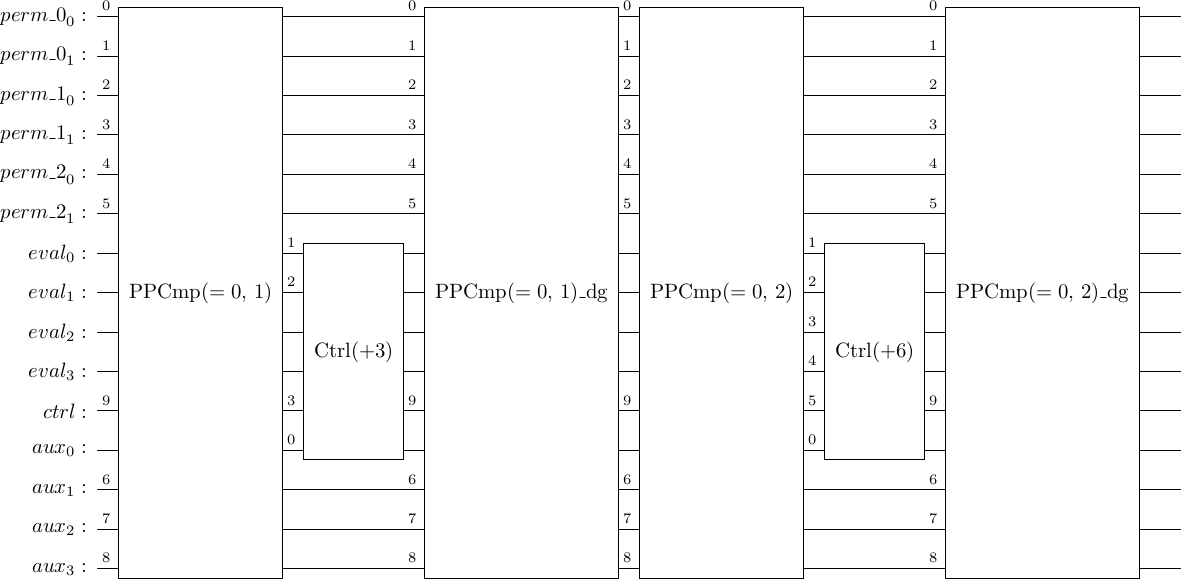

In [20]:
perm_eval_sym = PermEvaluation(num_states, Q2, num_eval_qubits)
print("Adjusted cost matrix =")
print(perm_eval_sym.adjusted_costs)
perm_eval_sym.decompose().draw(fold=-1)

Quick test with $Q_2$ ($min(10, n!)$ random samples) for correctness.

In [ ]:
correct = True
samples = []
perm_eval_sym = PermEvaluation(num_states, Q2, num_eval_qubits)

for perm in random.sample(list(permutations(range(num_states))), min(10, factorial(num_states))):
    samples.append(f"permutation={perm}")
    
    qr_perm_states = []
    for i in range(num_states):
        qr_perm_states.append(QuantumRegister(num_state_qubits, f"perm_{i}"))
    qr_eval = QuantumRegister(num_eval_qubits, "eval")
    qr_aux = QuantumRegister(perm_eval_sym.num_ancillas, "aux")
    qc = QuantumCircuit(*qr_perm_states, qr_eval, qr_aux)
        
    for p_index, value in enumerate(perm):
        for index, bit in enumerate(reversed(bin(value)[2:])):
            if bit == '1':
                qc.x(qr_perm_states[p_index][index])
    
    qc.compose(perm_eval_sym, inplace=True)
    qc.measure_all()
    result_sim = backend_sim.run(transpile(qc, backend_sim), shots=100).result()
    tr_counts, _, result_regs, aux_regs = translate_counts(result_sim.get_counts())
    
    evaluation = evaluate_perm(perm, perm_eval_sym.adjusted_costs)
    if len(result_regs) > 1 or result_regs[0] != evaluation or aux_regs[0] != 0:
        print("Wrong result!")
        print(f"Input: permutation={perm}, perm_eval={evaluation}")
        print("State counts:", tr_counts)
        correct = False
            
if (correct):
    print("All of the random samples were correct:", samples)

All of the random samples were correct: ['permutation=(0, 1, 2, 3)', 'permutation=(2, 3, 0, 1)', 'permutation=(0, 1, 3, 2)', 'permutation=(1, 3, 2, 0)', 'permutation=(3, 0, 2, 1)', 'permutation=(1, 0, 3, 2)', 'permutation=(0, 3, 2, 1)', 'permutation=(3, 2, 1, 0)', 'permutation=(1, 2, 0, 3)', 'permutation=(1, 2, 3, 0)']
